<a href="https://colab.research.google.com/github/hughharford/katas-python/blob/main/lwb_DL_cifar_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10 Classification Problem

🎯 **Exercise objectives**

1. Implement a CNN to solve a **`10-class classification problem`**
2. Enhance the CNN's performance with **`Data Augmentation Techniques`**
3. Experiment the **`Acceleration of GPU for Image Processing with Google Colab`**

<hr>


👏 You should now have a better feeling of:
* how CNNs works, 
* and especially how the convolutions are affecting images to detect specific features. 

🚀 It's time to play with images that are a bit more complex than the handwritten digits or the triangles/circles. 

🎨 From [Wikipedia](https://en.wikipedia.org/wiki/CIFAR-10) (*click on the link for further information*):

> The **`CIFAR-10`** dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<img src="https://people.minesparis.psl.eu/fabien.moutarde/ES_MachineLearning/mini-projets/cifar10_notebook_fichiers/cifar_10.png">

⭐️ This dataset is emblematic in the research community as many enhancements for image recognition have been achieved on this dataset. Once researchers achieved great performances on this dataset, they moved to a more advanced one, the CIFAR-100.

From the [University of Toronto](https://www.cs.toronto.edu/~kriz/cifar.html):

> This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is the list of classes in the CIFAR-100:


🔥 In this notebook, let's implement a CNN to distinguish the 10 categories from the CIFAR-10 dataset.

❗️ Again, remember that until 10 years ago, this problem was very challenging for the entire research community. As you have been sharpening your CNN skills, it's time to shine !


## (0) Colab

You are strongly advised to use **`Google Colab`** for this challenge and the rest of this Deep Learning Module.

* Read this <a href="https://kitt.lewagon.com/knowledge/tutorials/data_google_colab">tutorial on Kitt</a>

*  **If you follow our advice to use Colab, make sure to use the GPU acceleration** by clicking on:
    * `Runtime` $\rightarrow$ `Change runtime` $\rightarrow$ `GPU`

## (1) Loading the CIFAR10 Dataset

❓ **Question: Loading the CIFAR10 Dataset** ❓


* 🎁 We took care of the  `data loading and preprocessing` for you. 
* ▶️ Just run the following cell and make sure you understand the code.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import datasets
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np

(images_train, labels_train), (images_test, labels_test) = cifar10.load_data()

labels = ['airplane', 
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

170508288/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


{0: 5000,
 1: 5000,
 2: 5000,
 3: 5000,
 4: 5000,
 5: 5000,
 6: 5000,
 7: 5000,
 8: 5000,
 9: 5000}

### (1.1) Working on a smaller dataset  ?

❓ **Question about the training size**❓

* $50 000$ images may take a long time to train...
* 👨🏻‍🏫 **Always start with a subsample to iterate quickly** before scaling up 🏫
* Run the next cell where we are dividind the dataset size by `reduction_factor = 10`. Don't try to increase it unless we ask you to do so...

In [ ]:
# Considering only 1/10th of the 50_000 images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(len(images_train), round(len(images_train)/reduction_factor))
idx_test =  np.random.choice(len(images_test), round(len(images_test)/reduction_factor))

# Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
images_train_small = images_train[idx_train]
images_test_small = images_test[idx_test]
# and their corresponding labels
labels_train_small = labels_train[idx_train]
labels_test_small = labels_test[idx_test]

print("------------------ Before -----------------")
print(images_train.shape, images_test.shape)

print("")

print("--- After applying the reduction factor ---")
print(images_train_small.shape, images_test_small.shape)

print("")
print("-"*43)

unique, counts = np.unique(labels_train_small, return_counts=True)
dict(zip(unique, counts))

------------------ Before -----------------
(50000, 32, 32, 3) (10000, 32, 32, 3)

--- After applying the reduction factor ---
(5000, 32, 32, 3) (1000, 32, 32, 3)

-------------------------------------------


{0: 502,
 1: 505,
 2: 547,
 3: 461,
 4: 466,
 5: 511,
 6: 481,
 7: 543,
 8: 495,
 9: 489}

👇 You are working with images.. so it would be a good idea to show some of them :)

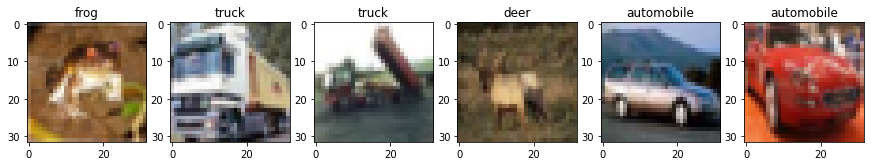

In [ ]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = images_train[i]
    label = labels_train[i][0]
    plt.imshow(img)
    plt.title(labels[label])

### (1.2) Image preprocesing

👉 As usual, let's:
- normalize the pixels' intensities between 0 and 1
- turn the `labels_train` and `labels_test` into "one-hot-encoded" targets that we will call respectively `y_train` and `y_cat`

In [ ]:
### Normalizing pixels' intensities

X_train = images_train / 255.
X_train_small = images_train_small / 255.
X_test = images_test / 255.
X_test_small = images_test_small / 255.

### Encoding the labels

y_train = to_categorical(labels_train, 10)
y_train_small = to_categorical(labels_train_small, 10)
y_test = to_categorical(labels_test, 10)
y_test_small = to_categorical(labels_test_small, 10)

In [ ]:
X_train_small.shape

(5000, 32, 32, 3)

## (2) Iterate on your CNN architecture using your small training set




❓ **Question** ❓ Time to shine ⭐️⭐️⭐️ !

1. Define the CNN architecture of your choice in an `initialize_model()` function:
2. Compile your model in a `compile_model()` method:
3. Fit your CNN only on the `small training set` and save the training information in an `history` variable
---
* Feeling lost ?
* Do you want to improve your performance ? 

<details>
    <summary>🆘 PRO TIPS 🆘  </summary>


- Do not forget to add the **`input shape`** of your images to the first layer: it has 3 colors
- **`Start simple, complexify later `** after several attempts to get better results
- The task is complex: **`Try at least 3 or 4 convolutions`**, you want your **images to go through different magnifying glasses / kernels from different convolutional layers !**
- The Kernel Size do not need to be large for such a small picture resolution!
- Add some **`MaxPooling2D`** (but not too much, otherwise the activation "image" will become too small)
- Keep `padding = "same"` and `stride = (1,1)` to start with.
- Once your model overfits, try to add some **`Dropout Layers` to regularize the network**. A good tip is to **increase the Dropout Rate/Strength as you move closer to the prediction layer** to prevent your CNN from overfitting
- Images are so small on the CIFAR10, you can afford to use a larger batch size (32 or 64) to benefit from even **more GPU parallelization** !
</details>

---

In [ ]:
# took initially from previous exercise...

def initialize_model():
    
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(4,4), input_shape=(32,32,3), activation='relu', padding="same", strides=(1,1)))

    model.add(layers.Conv2D(32, kernel_size=(4,4), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    model.add(layers.Conv2D(64, kernel_size=(4,4), activation='relu'))

    model.add(layers.Conv2D(64, kernel_size=(2,2), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    ### Flattening
    model.add(layers.Flatten())
    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(32, activation='relu')) # intermediate layer
    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='sigmoid'))
    

    return model

In [ ]:
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    ### Model compilation
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])    
    return model

In [ ]:
first_gcl_model = initialize_model()

In [ ]:
first_gcl_model = compile_model(first_gcl_model)

In [ ]:
es = EarlyStopping(patience=4, restore_best_weights=True, monitor='loss')


In [ ]:
history = first_gcl_model.fit(
                    X_train_small, 
                    y_train_small, 
                    callbacks = [es],
                    validation_split=0.3,
                    epochs=15,
                    batch_size=32,
                   verbose = 1)

Epoch 1/15
110/110 [==============================] - 2s 16ms/step - loss: 2.2362 - accuracy: 0.1569 - val_loss: 2.1331 - val_accuracy: 0.1993
Epoch 2/15
110/110 [==============================] - 1s 12ms/step - loss: 1.9902 - accuracy: 0.2734 - val_loss: 1.9005 - val_accuracy: 0.3027
Epoch 3/15
110/110 [==============================] - 1s 13ms/step - loss: 1.7542 - accuracy: 0.3631 - val_loss: 1.7690 - val_accuracy: 0.3680
Epoch 4/15
110/110 [==============================] - 1s 12ms/step - loss: 1.6404 - accuracy: 0.4103 - val_loss: 1.7330 - val_accuracy: 0.3740
Epoch 5/15
110/110 [==============================] - 1s 13ms/step - loss: 1.5184 - accuracy: 0.4557 - val_loss: 1.5466 - val_accuracy: 0.4480
Epoch 6/15
110/110 [==============================] - 1s 12ms/step - loss: 1.4024 - accuracy: 0.5043 - val_loss: 1.5328 - val_accuracy: 0.4620
Epoch 7/15
110/110 [==============================] - 1s 13ms/step - loss: 1.2946 - accuracy: 0.5374 - val_loss: 1.4792 - val_accuracy: 0.4527

❓ **Question: History of your training** ❓ 

Run the following function on the previous history 
_(keep the default arguments, these are intended for future plots in the notebook)_

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

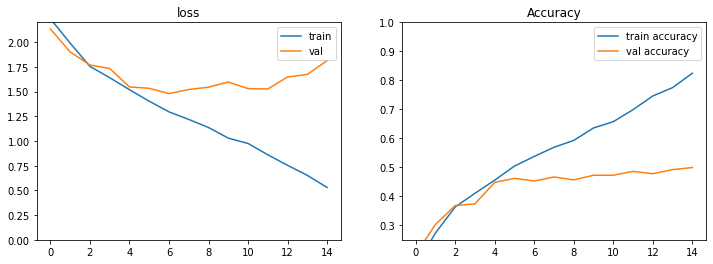

In [ ]:
plot_history(history, title='', axs=None, exp_name="");

❓ **Question: Evaluating your CNN** ❓ 

* Evaluate your model on the test data and compare it with a baseline accuracy. 
* Are you satisfied with these performances ? 
* Look at the `PRO TIPS` above and iterate a bit if you want to improve your performances!

### HSTH ANSWER:
1. Dreadful model

## (3) Increase the size of your training data

❓ **Question: train your model on the full dataset** ❓ 

- Switch to **Colab** if you haven't done it before
- Make sure to use the **GPU acceleration** by clicking on `Runtime` $\rightarrow$ `Change runtime` $\rightarrow$ `GPU`

💡 Training neural networks on images (in each batch) can be parallelized, and this **`parallelization procedure`** can be done on **`GPU`**.

---

You should witness significant performance improvement

Welcome to the Deep Learning paradigm, where big data makes a significant difference.

But what happens if I can access only a limited amount of pictures ? Think about biologists studying rare species. What can they do ?
* To improve the accuracy of a model without much work, we can **generate new data**. 
* The process is called... ⭐️ **`Data Augmentation`** ⭐️ ! 
</details>

## (4) Data augmentation

* 👩🏻‍🏫 <b><u>Data Augmentation</u></b>
    * This technique is widely-used technique consists in applying little transformations to the input images without changing their labels: ***mirroring***, ***cropping***, ***intensity changes***, etc... 
    * The _improved performance_ simply results from the CNN training with more images (the original pictures + the "augmented" ones).
    

* 👉 <b><u>Theoretically:</u></b>
    * (1) We could generate these new images by applying some transformations on copies of the original picturnes
    * (2) Train the model on the original images + new images. 
    
    
* 🚨  <b><u>Problem:</u></b>
    * Such a procedure requires to store all these images in memory...
    * It can be very intensive, to the point that your computer RAM cannot hold any additional new image
    
    
* 🦄 <b><u>In Practice:</u></b>
    * When a Neural Network operates a forward/backward propagation, it requires to see only 16 pictures at a time if you chose $ batch size = 16 $ for example. It doesn't need to store neither all the original images nor the augmented images in the RAM.
    * For this reason, we will **augment the data on the fly (batch per batch)**. What does it mean ? For every epoch and every batch, during the ***.fit()*** training procedure, we will:
        1. Generate some `augmented data/images`
        2. Fit the model on the images and their augmented versions
        3. Delete the images and their augmented versions from the RAM
        4. Repeat steps 1-2-3
        
* 📚 <a href= "https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator"><b><u>tf/keras/preprocessing/image/ImageDataGenerator:</u></b></a>

❓ **Question: using an ImageDataGenerator** ❓

Look at the following code down below 👇
* The general syntax may look strange but don't worry: 
    * First, focus on the arguments of the *ImageDataGenerator* which defines the augmentation techniques that we are using
    * and then check the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">**`ImageDataGenerator`**</a> documentation later
 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = False,
    featurewise_std_normalization = False,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    zoom_range = (0.8, 1.2),
    ) 

datagen.fit(X_train)
datagen

In [ ]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

❗️ Always **visualize the augmented images** in order to double-check whether you can still recognize the labels yourself or not ❗️

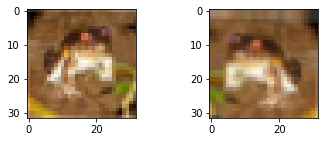

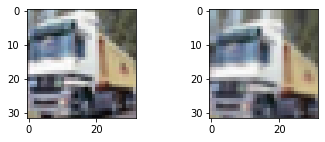

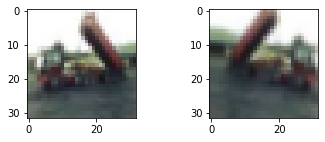

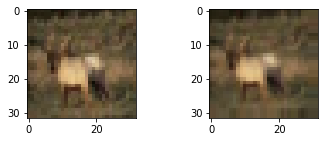

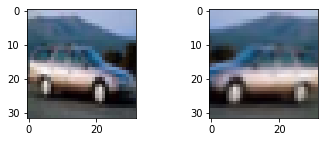

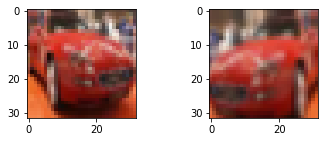

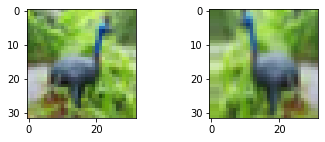

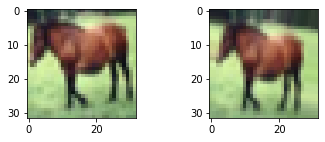

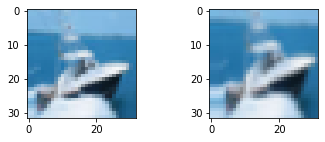

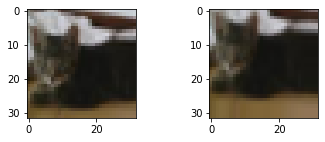

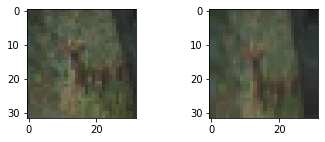

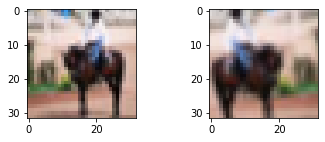

In [ ]:
import numpy as np

for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()
    
    if i > 10:
        break

❗ **Remarks** ❗ 

* Each image from **`X_augmented_iterator`** is an ***augmented image*** of one image located in the original `X_train` image dataset
* This augmentation process is done once per epoch.
* During one epoch, the model will:
    1. *create the augmented version* of each picture from `X_train`, 
    2. for each image of `X_train`, *the model will randomly pick either the original version in `X_train` or its augmented version in `X_augmented_iterator`*
    3. and the model will be *fitted on the combination of some original images + some augmented images*

---



❓ **Question: what is the validation set when we have augmented images** ❓ 

* Previously, we used the `validation_split` argument to let the model separate the training set into a Train/Validation split when fitting the model for each epoch.
* It is not possible to use this kind of Train/Val Split here as **using an image in the training set and its transformation in the validation set is considered as a `data leakage`** !. 
* Therefore, we have to define the **`validation_data`** manually with the following commands: take time to understand the cell down below:👇 


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# The model
model_aug = initialize_model()
model_aug = compile_model(model_aug)

# The data generator
X_tr = X_train[:40000]
y_tr = y_train[:40000]
X_val = X_train[40000:]
y_val = y_train[40000:]
train_flow = datagen.flow(X_tr, y_tr, batch_size = 64)

# The early stopping criterion
es = EarlyStopping(patience = 3)

# The fit
history_aug = model_aug.fit(train_flow, 
                        epochs = 50, 
                        callbacks = [es], 
                        validation_data = (X_val, y_val))


🚨 The training can be quite long here...

👉 Feel free to move on to the next exer|ise and come back later to this notebook to finish the last questions

❓ **Question: How did the model with an augmented dataset perform ?** ❓ 

Let's plot the previous and current run histories. What do you think of the data augmentation?

In [ ]:
# YOUR CODE HERE

🥡 <b><u>Some takeaways from Data Augmentation:</u></b>

* Data augmentation may not improve your performance easily...

* Here it even decreased the performance!

* Its impact strongly depends on 
    * the model architecture you used
    * the learning rate, 
    * the type of augmentation chosen, etc...

* Image classification is an art that requires months and years of practice to master!

🚨 **Don't spend too much time trying to finetune your model for the moment !  You have 3 other interesting challenges to investigate!**. 🚨

📚 [Here is a good example of a solution for future reference](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/).<br>
They managed to reach an accuracy level of approx. 80%

---

🏁 **Congratulations** 🏁 

1. Download this notebook from your `Google Drive` or directly from `Google Colab` 
2. Drag-and-drop it from your `Downloads` folder to your local `[GITHUB_USERNAME]/data-challenges/06-Deep-Learning/03-Convolutional-Neural-Networks/03-Cifar-Classification`


💾 Don't forget to push your 

3. Follow the usual procedure on your terminal in the `06-Deep-Learning/03-Convolutional-Neural-Networks/03-Cifar-Classification` folder:
      * *git add cifar_classification.ipynb*
      * *git commit -m "I am the god of CNNs"*
      * *git push origin master*

*Hint*: To find where this Colab notebook has been saved, click on `File` $\rightarrow$ `Locate in Drive`.

🚀 It is time to move on to the **Transfer Learning** challenge!